# Measuring company similarities using text data

By: Filip Mellgren 2023

This is a "skills project" for the 2023 course in labor economics taught by Mitchell Downey and Horng Chern Wong at Stockholnm University. The idea is to practice a certain skill that can be useful in future research and is meant to be a small project where we get our hands dirty. 

Hoberg, Phillips (2016), HP, pionered an approach to measure product similarities using text data and made a data set of such product similarities publicly available, see http://hobergphillips.tuck.dartmouth.edu/. For their data set, they make use of product descriptions available for public American corporations, the so called 10-K form fillings. To measure similarities, HP calculate word frequency and apply the cosine similarity algorithm. Higher values indicate closer (multi-dimensional) angle between two word representations, which means many words are shared between the two text inputs. If many words are shared, the idea is that two products share common features and are thus close substitutes.

Inspired by HP, I want to do something similar for Swedish firms. HP uses product desciptions, but for this project, I will use wikipedia pages containing company descriptions to estimate the matrix $$\mathbf{A'A}$$ of cosine similarities. The project therefore starts with scraping data from Wikipedia, where my starting point is a Wikipedia page containing a table of Swedish firms with some descriptions. I scrape the full table, and then follow each individual link to download the Wikipedia page of each entry in that table. I save each Wikipedia page's text to a file for each entry in the table. I then use these saved files as input to the cosines similarity algorithm to calculate a number and populate a matrix. Finally, I do a simple visualization of the scraped data before concluding the project.

Further steps can follow the spirit of Bruno Pellegrino's Job Market Paper, where he uses the similarity matrix to estimate inverse demand and cross price elasticities of demand. In order to do that, he links the firms to price and quantity data, which I don't have, but this is a possible theoretical extension that may be feasible for industry specific studies where price data is available.

In [49]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import math
import re
from collections import Counter
#import itertools
import numpy as np
import plotly.express as px
import pandas as pd
import os
import urllib.request
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt


## Starting point, scrape basic information

I will start at [this Wikipedia page]("https://en.wikipedia.org/wiki/List_of_companies_of_Sweden"), which contains a list of many Swedish firms. It is by no means exhaustive but contains a decent number of companies and I think it is enough for this project.

I found [this link](https://alanhylands.com/how-to-web-scrape-wikipedia-python-urllib-beautiful-soup-pandas/) which helps me scrape the Wikipedia table. So let's start from there to get the table into Python.

In [50]:

url = "https://en.wikipedia.org/wiki/List_of_companies_of_Sweden"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")
all_tables=soup.find_all('table', class_='wikitable sortable')

rows = all_tables[1].findAll('tr') # 'tr' = table row
header = rows[0]

colnames = ['link']
for col in header.findAll('th'):
    colnames.append(col.text.strip())

data_list = []
for row in rows:
    data_row = []
    try:
        link = row.find('a').get('href')
    except AttributeError:
        link = ''
    data_row.append(link)
    for col in row.findAll('td'):
        data_row.append(col.text.strip())
    data_list.append(data_row)
    
df = pd.DataFrame(data_list, columns = colnames)
df

link             Name           Industry  \
0                                       None               None   
1       /wiki/3H_Biomedical    3H Biomedical        Health care   
2     /wiki/AarhusKarlshamn  AarhusKarlshamn     Consumer goods   
3        /wiki/Abba_Seafood     Abba Seafood     Consumer goods   
4          /wiki/ABU_Garcia       ABU Garcia     Consumer goods   
..                      ...              ...                ...   
298  /wiki/Wayne%27s_Coffee   Wayne's Coffee  Consumer services   
299              /wiki/WESC             WESC     Consumer goods   
300           /wiki/WG_Film          WG Film  Consumer services   
301           /wiki/WM-data          WM-data         Technology   
302    /wiki/X5_Music_Group   X5 Music Group  Consumer services   

                           Sector Headquarters Founded  \
0                            None         None    None   
1                   Biotechnology      Uppsala    2004   
2                   Food products        Malmö    2005   
3                   Food products   Gothenburg    1883   
4           Recreational products  Svängsta[5]    1921   
..                            ...          ...     ...   
298            Restaurants & bars    Stockholm    1994   
299        Clothing & accessories    Stockholm    1999   
300  Broadcasting & entertainment        Malmö    1994   
301                      Software    Stockholm    1969   
302  Broadcasting & entertainment    Stockholm    2003   

                                         Notes  
0                                         None  
1                           Cell-based biotech  
2                         Vegetable oils, fats  
3                                      Seafood  
4    Fishing reels, part of Newell Brands (US)  
..                                         ...  
298                          Coffeehouse chain  
299                                   Clothing  
300                            Film production  
301                IT consulting, defunct 2008  
302                           Music recordings  

[303 rows x 7 columns]

Neat, the table contains a bunch of information that could potentially be useful. However, I care about the `link` column which contains links to various Wikipedia entries, which leads us to the next section.

## Scrape text data

In this section, I scrape all wikipedia pages in the `link`column of the table above. 

In [51]:
def scrape_page(link):
    '''' Scrape the page of a given link and saves it as a .txt file.
    Input: link (str)
    Output: None

    '''
    
    url = "https://en.wikipedia.org/" + link
    
    if os.path.isfile(link[1:] + ".txt"):
        return
    time.sleep(0.3)
    driver.get(url)
    element = driver.find_element(By.ID , 'bodyContent')
    try :
        with open(link[1:] + ".txt", "w") as text_file:
            text_file.write(element.text)
    except FileNotFoundError:
        pass
    return


In [52]:
driver = webdriver.Chrome()
for i in range(1, df.shape[0]):
    link = df.iloc[i, 0]
    scrape_page(link)

We have now scraped all the links in our table and stored the Wikipedia text as .txt-files and can move on to the next step.

## Calculate similarity score

Here, we use cosine similarity algorithm to define how similar two bodies of text are and apply it to our scraped Wikipedia data.

In [53]:
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    ''' Calculate cosine similarity between two vectors.
    Most code comes from: 
    https://stackoverflow.com/questions/15173225/calculate-cosine-similarity-given-2-sentence-strings
    Input: vec1, vec2 (dict)
    Output: cosine similarity (float)
    '''
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    ''' Convert text to vector.
    Input: text (str)
    Output: vector (dict)
    '''
    words = WORD.findall(text)
    return Counter(words)
    
def file_to_vector(file):
    ''' Convert file to vector.
    Input: file (str) path to a file
    Output: vector (dict)
    '''
    try:
        with open(file, 'r') as f:
            text = f.read()
    except FileNotFoundError:
        print("path not found")
        return
    return text_to_vector(text)

With the functions in place, we can use them to loop over all pairs of files, and thereby calculate the mesure we care about, the cosine distance metric.

The nested for loop algorithm is a little slow, it should take ca 30 seconds to run. 

In [54]:
# Loop over all files in wiki folder
n_files = len(os.listdir('wiki'))
distances = np.zeros((n_files-1, n_files-1))
for count1, file in enumerate(os.listdir('wiki')):
    remaining = os.listdir('wiki')[count1:]
    file = 'wiki/' + file
    vector1 = file_to_vector(file)
    for count2, file2 in enumerate(remaining): 
        file2 = 'wiki/' + file2
        vector2 = file_to_vector(file2)
        cosine = get_cosine(vector1, vector2)
        distances[count1 - 1, count2 - 1] = cosine
        

We now have the following matrix. Notice how only half is populated. Because of symmetry, we know what the other half will look like, so let's turn this matrix around and impose symmetry on it.

In [55]:
fig = px.imshow(distances)
fig.show()


In [56]:
distances = np.flipud(distances)
distances = distances + distances.T - np.diag(distances.diagonal())
fig = px.imshow(distances)
fig.show()

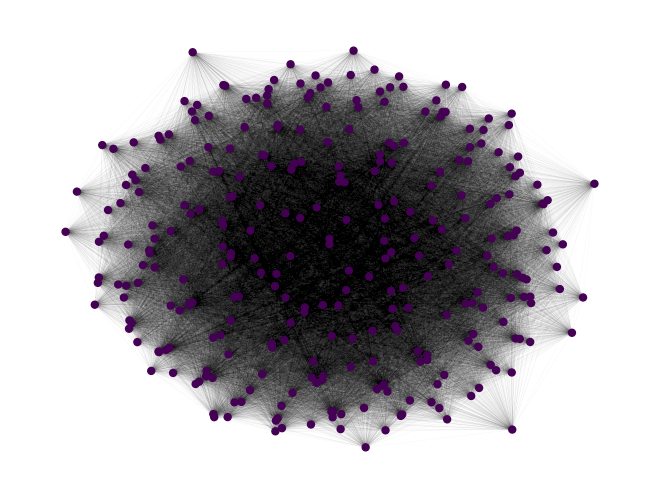

In [57]:

n = np.shape(distances)[0]
# Create graph from distance matrix
G = nx.Graph()
for i in range(n):
    for j in range(i+1, n):
        G.add_edge(i, j, weight=distances[i, j])

# Compute positions of nodes using Fruchterman-Reingold algorithm
pos = nx.spring_layout(G, seed=42)

# Draw graph with nodes colored by their degree centrality
degree_centrality = nx.degree_centrality(G)
node_color = [degree_centrality[i] for i in G.nodes()]
node_size = [25*degree_centrality[i] for i in G.nodes()]
nx.draw(G, pos, node_color=node_color, node_size=node_size, with_labels=False, width = 0.01)

# Show the plot
plt.show()

And there we have it! It seems there are no specific clusters in this data and that everything is rather uniform. Perhaps because we did not spend time cleaning the Wikipedia files of elements that are common across all articles. 